# PRE-PROCESS


In [ ]:
import os
import numpy as np
from PIL import Image
from concurrent.futures import ThreadPoolExecutor
import matplotlib.pyplot as plt

# -------------- Preprocessing Utilities --------------
def convert_to_rgb_array(image):
    if image.ndim == 2:
        return np.stack([image]*3, axis=-1).astype(np.uint8)
    elif image.shape[2] == 4:
        return image[:, :, :3]
    return image

def gaussian_blur(img, kernel_size=5, sigma=1.0):
    def gaussian(x, y):
        return (1.0 / (2.0 * np.pi * sigma**2)) * np.exp(-(x**2 + y**2)/(2*sigma**2))

    k = kernel_size // 2
    kernel = np.array([[gaussian(x, y) for x in range(-k, k+1)] for y in range(-k, k+1)])
    kernel /= np.sum(kernel)

    padded = np.pad(img, ((k, k), (k, k), (0, 0)), mode='reflect')
    blurred = np.zeros_like(img)

    for c in range(3):
        for i in range(img.shape[0]):
            for j in range(img.shape[1]):
                region = padded[i:i+kernel_size, j:j+kernel_size, c]
                blurred[i, j, c] = np.sum(region * kernel)
    return blurred.astype(np.uint8)

def sharpen_image(img):
    kernel = np.array([[0, -1,  0],
                       [-1,  5, -1],
                       [0, -1,  0]])
    k = 1
    padded = np.pad(img, ((k, k), (k, k), (0, 0)), mode='reflect')
    sharp = np.zeros_like(img)
    for c in range(3):
        for i in range(img.shape[0]):
            for j in range(img.shape[1]):
                region = padded[i:i+3, j:j+3, c]
                sharp[i, j, c] = np.clip(np.sum(region * kernel), 0, 255)
    return sharp.astype(np.uint8)

def rgb_to_ycrcb(image):
    img = image.astype(np.float32)
    Y = 0.299*img[:,:,0] + 0.587*img[:,:,1] + 0.114*img[:,:,2]
    Cr = (img[:,:,0] - Y) * 0.713 + 128
    Cb = (img[:,:,2] - Y) * 0.564 + 128
    return np.stack([Y, Cr, Cb], axis=-1).astype(np.uint8)

def strict_skin_mask(img):
    ycrcb = rgb_to_ycrcb(img)
    Cr = ycrcb[:,:,1]
    Cb = ycrcb[:,:,2]
    mask = np.logical_and.reduce((Cr > 135, Cr < 175, Cb > 90, Cb < 135))
    return mask.astype(np.uint8) * 255

def remove_small_components(mask, min_size_ratio=0.02):
    h, w = mask.shape
    total_pixels = h * w
    visited = np.zeros_like(mask, dtype=bool)
    output = np.zeros_like(mask)

    def dfs(i, j, label_map):
        stack = [(i, j)]
        count = 0
        while stack:
            x, y = stack.pop()
            if not (0 <= x < h and 0 <= y < w): continue
            if visited[x, y] or mask[x, y] == 0: continue
            visited[x, y] = True
            label_map.append((x, y))
            count += 1
            for dx, dy in [(-1,0),(1,0),(0,-1),(0,1)]:
                stack.append((x+dx, y+dy))
        return count

    for i in range(h):
        for j in range(w):
            if not visited[i, j] and mask[i, j] == 255:
                label_map = []
                size = dfs(i, j, label_map)
                if size > total_pixels * min_size_ratio:
                    for x, y in label_map:
                        output[x, y] = 255
    return output

def apply_mask_on_black_background(original, mask):
    output = np.zeros_like(original)
    for c in range(3):
        output[:, :, c] = np.where(mask == 255, original[:, :, c], 0)
    return output

def normalize_image(img):
    return img.astype(np.float32) / 255.0

def preprocess_hand_image_pil(pil_image):
    img = convert_to_rgb_array(np.array(pil_image))
    blurred = gaussian_blur(img, kernel_size=5, sigma=1.2)
    sharpened = sharpen_image(blurred)
    skin = strict_skin_mask(sharpened)
    cleaned = remove_small_components(skin)
    final_masked = apply_mask_on_black_background(sharpened, cleaned)
    return Image.fromarray(final_masked)

# -------------- Batch Processing Code --------------

input_root = 'asl_alphabet_train'
output_root = 'Preprocessed data'

if not os.path.exists(output_root):
    os.makedirs(output_root)

def process_image(input_file_path, output_file_path):
    try:
        with Image.open(input_file_path) as img:
            processed_img = preprocess_hand_image_pil(img)
            processed_img.save(output_file_path, 'JPEG')
    except Exception as e:
        print(f"Error processing file: {input_file_path} - {e}")

def process_folder(input_subfolder_path, output_subfolder_path):
    if not os.path.exists(output_subfolder_path):
        os.makedirs(output_subfolder_path)

    all_filenames = [filename for filename in os.listdir(input_subfolder_path)
                     if os.path.isfile(os.path.join(input_subfolder_path, filename))]

    selected_filenames = all_filenames[:1000]

    files = [(os.path.join(input_subfolder_path, filename),
              os.path.join(output_subfolder_path, os.path.splitext(filename)[0] + '.jpg'))
             for filename in selected_filenames]

    batch_size = 16
    for i in range(0, len(files), batch_size):
        batch = files[i:i + batch_size]
        with ThreadPoolExecutor(max_workers=16) as executor:
            executor.map(lambda args: process_image(*args), batch)

def main():
    for subfolder in os.listdir(input_root):
        input_subfolder_path = os.path.join(input_root, subfolder)
        if not os.path.isdir(input_subfolder_path):
            continue
        output_subfolder_path = os.path.join(output_root, subfolder)
        process_folder(input_subfolder_path, output_subfolder_path)

if __name__ == '__main__':
    main()



# MODEL TRAINING


Using device: cpu
1: 200 train, 40 test images loaded.
10: 200 train, 40 test images loaded.
2: 200 train, 40 test images loaded.
3: 200 train, 40 test images loaded.
4: 200 train, 40 test images loaded.
5: 200 train, 40 test images loaded.
6: 200 train, 40 test images loaded.
7: 200 train, 40 test images loaded.
8: 200 train, 40 test images loaded.
9: 200 train, 24 test images loaded.
A: 200 train, 40 test images loaded.
B: 200 train, 40 test images loaded.
C: 200 train, 40 test images loaded.
D: 200 train, 40 test images loaded.
E: 200 train, 40 test images loaded.
F: 200 train, 40 test images loaded.
G: 200 train, 40 test images loaded.
H: 200 train, 40 test images loaded.
I: 200 train, 40 test images loaded.
J: 200 train, 40 test images loaded.
K: 200 train, 40 test images loaded.
L: 200 train, 40 test images loaded.
M: 200 train, 40 test images loaded.
N: 200 train, 40 test images loaded.
O: 200 train, 40 test images loaded.
P: 200 train, 40 test images loaded.
Q: 200 train, 40 te

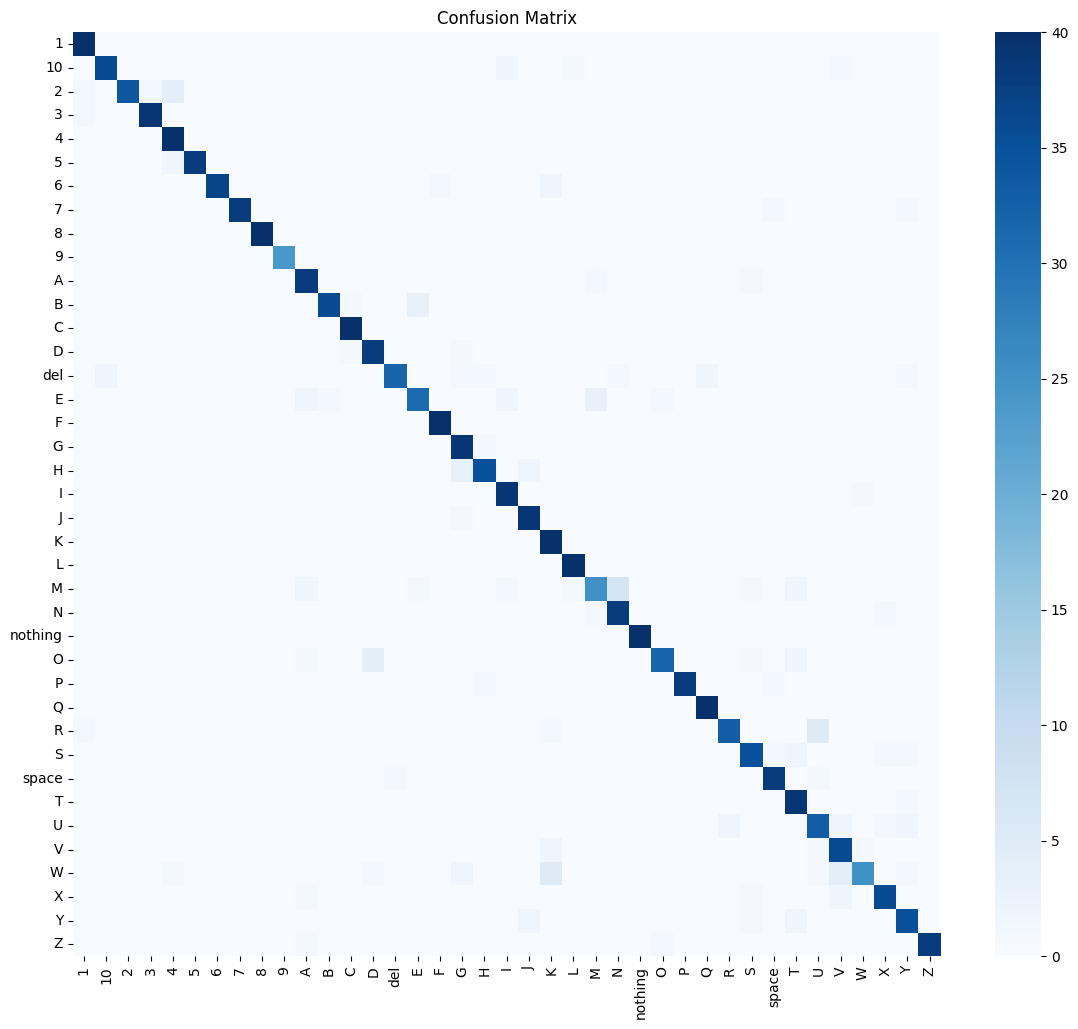

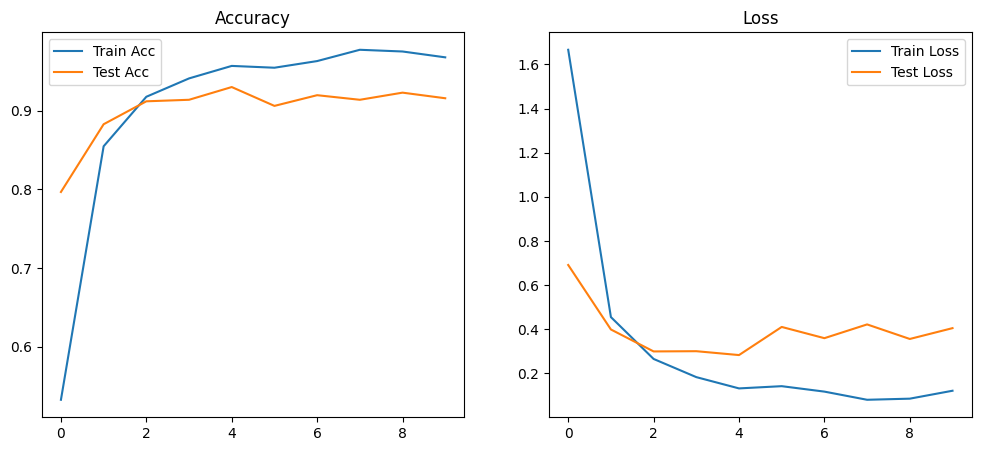

✅ Model saved as 'asl_cnn_39class_cpu.pth'


In [3]:
# 1. IMPORTS
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd
import random

# 2. DEVICE CONFIG (Force CPU)
device = torch.device("cpu")
print("Using device:", device)

# 3. CLASS LABELS
labels = [
    '1', '10', '2', '3', '4', '5', '6', '7', '8', '9',
    'A', 'B', 'C', 'D', 'del', 'E', 'F', 'G', 'H', 'I',
    'J', 'K', 'L', 'M', 'N', 'nothing', 'O', 'P', 'Q',
    'R', 'S', 'space', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'
]
label_map = {label: idx for idx, label in enumerate(labels)}
num_classes = len(labels)

# 4. LOAD IMAGES FROM FOLDERS (200 train + 40 test per class)
def load_data(base_path, image_size=32, train_limit=200, test_limit=40):
    X_train, y_train, X_test, y_test = [], [], [], []
    for folder in sorted(os.listdir(base_path)):
        if folder not in label_map:
            continue
        folder_path = os.path.join(base_path, folder)
        if not os.path.isdir(folder_path):
            continue

        all_images = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        random.shuffle(all_images)
        total_needed = train_limit + test_limit
        used_images = all_images[:total_needed]
        train_images = used_images[:train_limit]
        test_images = used_images[train_limit:]

        label_idx = label_map[folder]

        for file in train_images:
            img_path = os.path.join(folder_path, file)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (image_size, image_size))
                X_train.append(img)
                y_train.append(label_idx)

        for file in test_images:
            img_path = os.path.join(folder_path, file)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (image_size, image_size))
                X_test.append(img)
                y_test.append(label_idx)

        print(f"{folder}: {len(train_images)} train, {len(test_images)} test images loaded.")

    print(f"\n✅ Total Loaded: {len(X_train)} train and {len(X_test)} test images")
    return np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test)

# 5. LOAD DATA
X_train, y_train, X_test, y_test = load_data(".", image_size=32)

# Normalize
X_train = X_train.astype("float32") / 255.0
X_test = X_test.astype("float32") / 255.0

# 6. CUSTOM DATASET
class ASLDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X).permute(0, 3, 1, 2)  # NHWC -> NCHW
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = ASLDataset(X_train, y_train)
test_dataset = ASLDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 7. CNN MODEL
class ASLCNN(nn.Module):
    def __init__(self):
        super(ASLCNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1), nn.ReLU(),
            nn.BatchNorm2d(64), nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(),
            nn.BatchNorm2d(128), nn.MaxPool2d(2), nn.Dropout(0.2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1), nn.ReLU(),
            nn.BatchNorm2d(256), nn.MaxPool2d(2),

            nn.Flatten(), nn.Dropout(0.2),
            nn.Linear(256 * 4 * 4, 1024), nn.ReLU(),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        return self.model(x)

model = ASLCNN().to(device)

# 8. TRAINING CONFIG
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 10

train_acc, test_acc = [], []
train_loss, test_loss = [], []

# 9. TRAINING LOOP
for epoch in range(epochs):
    model.train()
    total, correct, running_loss = 0, 0, 0

    for imgs, lbls in train_loader:
        imgs, lbls = imgs.to(device), lbls.to(device)
        out = model(imgs)
        loss = loss_fn(out, lbls)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(out, 1)
        correct += (preds == lbls).sum().item()
        total += lbls.size(0)

    acc = correct / total
    train_acc.append(acc)
    train_loss.append(running_loss / len(train_loader))

    # Evaluate
    model.eval()
    correct = total = test_running_loss = 0
    with torch.no_grad():
        for imgs, lbls in test_loader:
            imgs, lbls = imgs.to(device), lbls.to(device)
            out = model(imgs)
            loss = loss_fn(out, lbls)
            test_running_loss += loss.item()
            _, preds = torch.max(out, 1)
            correct += (preds == lbls).sum().item()
            total += lbls.size(0)

    acc = correct / total
    test_acc.append(acc)
    test_loss.append(test_running_loss / len(test_loader))

    print(f"Epoch {epoch+1}/{epochs} | Train Acc: {train_acc[-1]:.4f} | Test Acc: {test_acc[-1]:.4f}")

# 10. CONFUSION MATRIX
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for imgs, lbls in test_loader:
        out = model(imgs.to(device))
        _, preds = torch.max(out, 1)
        y_true.extend(lbls.numpy())
        y_pred.extend(preds.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cm, index=labels, columns=labels)
plt.figure(figsize=(14, 12))
sns.heatmap(df_cm, annot=False, cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# 11. PLOT TRAINING METRICS
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_acc, label="Train Acc")
plt.plot(test_acc, label="Test Acc")
plt.title("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_loss, label="Train Loss")
plt.plot(test_loss, label="Test Loss")
plt.title("Loss")
plt.legend()
plt.show()

# 12. SAVE MODEL
torch.save(model.state_dict(), "asl_cnn_39class_cpu.pth")
print("✅ Model saved as 'asl_cnn_39class_cpu.pth'")

In [4]:
import os
import random
import shutil

# === Define labels ===
labels = [
    '1', '10', '2', '3', '4', '5', '6', '7', '8', '9',
    'A', 'B', 'C', 'D', 'del', 'E', 'F', 'G', 'H', 'I',
    'J', 'K', 'L', 'M', 'N', 'nothing', 'O', 'P', 'Q',
    'R', 'S', 'space', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'
]

# === Set base directory ===
base_dir = os.getcwd()  # current directory where .py file is located
destination_dir = os.path.join(base_dir, "test")

# === Create test folder ===
os.makedirs(destination_dir, exist_ok=True)

# === Copy one random image per class ===
for class_name in labels:
    class_path = os.path.join(base_dir, class_name)
    
    if os.path.isdir(class_path):
        images = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        if images:
            selected_image = random.choice(images)
            source_image_path = os.path.join(class_path, selected_image)
            ext = os.path.splitext(selected_image)[1]
            dest_path = os.path.join(destination_dir, f"{class_name}{ext}")
            shutil.copy(source_image_path, dest_path)
            print(f"✅ Copied {selected_image} → test/{class_name}{ext}")
        else:
            print(f"⚠️ No images found in: {class_name}")
    else:
        print(f"❌ Folder not found: {class_name}")

print("\n✅ All available classes processed into 'test/' folder.")


✅ Copied 6c3ef975-57b6-45e4-b309-3ca61ee7e1c4.rgb_0000.png → test/1.png
✅ Copied 1c2f3ec1-9ce2-411a-9a85-9ec33b7c2434.rgb_0000.png → test/10.png
✅ Copied 9b0dd145-5211-4fec-97b3-de4c6442b764.rgb_0000.png → test/2.png
✅ Copied 7c8d98de-64fa-4520-a502-9b36a8863cb3.rgb_0000.png → test/3.png
✅ Copied b819f7c4-c6c7-4592-998c-23ac7d809869.rgb_0000.png → test/4.png
✅ Copied fb820fb1-9311-4e3b-95e1-7637650e9331.rgb_0000.png → test/5.png
✅ Copied f450573c-7ca5-47dd-9f0d-836f5c995993.rgb_0000.png → test/6.png
✅ Copied 0d3d2fcf-e97b-4067-b8ef-3a8ddac9c843.rgb_0000.png → test/7.png
✅ Copied 2b5eb4cf-fee3-48ef-9dd1-f99d74ae9d18.rgb_0000.png → test/8.png
✅ Copied 3bcbd770-4695-41ae-87fe-7295418465ce.rgb_0000.png → test/9.png
✅ Copied A421.jpg → test/A.jpg
✅ Copied B1179.jpg → test/B.jpg
✅ Copied C2136.jpg → test/C.jpg
✅ Copied D2210.jpg → test/D.jpg
✅ Copied del2581.jpg → test/del.jpg
✅ Copied E2751.jpg → test/E.jpg
✅ Copied F2678.jpg → test/F.jpg
✅ Copied G2280.jpg → test/G.jpg
✅ Copied H7.jpg → te

In [5]:
import os
import cv2
import torch
import torch.nn as nn
import numpy as np

# 1. CLASS LABELS
labels = [
    '1', '10', '2', '3', '4', '5', '6', '7', '8', '9',
    'A', 'B', 'C', 'D', 'del', 'E', 'F', 'G', 'H', 'I',
    'J', 'K', 'L', 'M', 'N', 'nothing', 'O', 'P', 'Q',
    'R', 'S', 'space', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'
]
num_classes = len(labels)

# 2. CNN CLASS (must match training model)
class ASLCNN(nn.Module):
    def __init__(self):
        super(ASLCNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1), nn.ReLU(),
            nn.BatchNorm2d(64), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(),
            nn.BatchNorm2d(128), nn.MaxPool2d(2), nn.Dropout(0.2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1), nn.ReLU(),
            nn.BatchNorm2d(256), nn.MaxPool2d(2),
            nn.Flatten(), nn.Dropout(0.2),
            nn.Linear(256 * 4 * 4, 1024), nn.ReLU(),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x): return self.model(x)

# 3. LOAD MODEL (CPU)
model = ASLCNN()
model.load_state_dict(torch.load("asl_cnn_39class_cpu.pth", map_location=torch.device("cpu")))
model.eval()

# 4. PREDICT FROM FOLDER
def predict_images_in_folder(folder_path, image_size=32):
    for file in os.listdir(folder_path):
        if not file.lower().endswith(('.jpg', '.png', '.jpeg')):
            continue
        path = os.path.join(folder_path, file)
        img = cv2.imread(path)
        if img is None:
            print(f"❌ Couldn't read image: {file}")
            continue
        img = cv2.resize(img, (image_size, image_size)).astype("float32") / 255.0
        img = torch.tensor(img).permute(2, 0, 1).unsqueeze(0)  # shape: (1, 3, 32, 32)

        with torch.no_grad():
            output = model(img)
            predicted_idx = torch.argmax(output, 1).item()
            predicted_label = labels[predicted_idx]
            print(f"{file} → {predicted_label}")

# 5. RUN
predict_images_in_folder("test")  

1.png → 1
10.png → 10
2.png → 2
3.png → 3
4.png → 4
5.png → 5
6.png → 6
7.png → 7
8.png → 8
9.png → 9
A.jpg → A
B.jpg → B
C.jpg → C
D.jpg → D
del.jpg → del
E.jpg → E
F.jpg → F
G.jpg → G
H.jpg → H
I.jpg → I
J.jpg → G
K.jpg → K
L.jpg → L
M.jpg → M
N.jpg → N
nothing.jpg → nothing
O.jpg → O
P.jpg → P
Q.jpg → Q
R.jpg → R
S.jpg → S
space.jpg → space
T.jpg → T
U.jpg → U
V.jpg → V
W.jpg → K
X.jpg → X
Y.jpg → Y
Z.jpg → Z
